Применим линейную регрессию на практике – попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили. Помимо этого узнаем, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные. 

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
import scipy
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [28]:
df = pd.read_csv('cars.csv')

In [29]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Сгенерируем первый признак.

Использовать полное название машины – не самый хороший вариант, поэтому создадим новый признак – марку автомобиля (company). Для этого используем столбец CarName, разобьем значения ячеек по пробелу и запишем в колонку первый элемент. Например:

'audi 100 ls' → 'audi'
Сколько всего уникальных марок машины встречается в датасете?

In [31]:
df['company'] = df.CarName.apply(lambda x: x.split(' ')[0])

In [32]:
df.drop(['car_ID', 'CarName'], axis=1, inplace=True)

In [33]:
df.company.nunique()

28

In [34]:
df.company.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

Теперь внимательнее посмотрим на уникальные значения company. Часть из них оказалась с ошибками!

'maxda' → 'mazda'
'Nissan' → 'nissan'
'porcshce' → 'porsche'
'toyouta' → 'toyota'
'vokswagen' & 'vw' → 'volkswagen'

Сколько уникальных производителей осталось в итоге?

In [35]:
df['company'] = df.company.str.lower().str.replace('maxda', 'mazda', regex=False) \
                                        .str.replace('porcshce', 'porsche', regex=False) \
                                        .str.replace('toyouta', 'toyota', regex=False) \
                                        .str.replace('vokswagen', 'volkswagen', regex=False) \
                                        .str.replace('vw', 'volkswagen', regex=False)
df.company.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [36]:
df.company.nunique()

22

Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них + не забываем что мы предсказываем price:

In [37]:
df2 = df[['company', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth',
         'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 'price']]

df2.head()

,company,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,price
0,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,13495.0
1,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,16500.0
2,alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,six,152,2.68,154,16500.0
3,audi,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,four,109,3.19,102,13950.0
4,audi,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,five,136,3.19,115,17450.0


Теперь посчитаем например корреляцию между price и другими переменными, например.

In [38]:
df2.corr()["price"].round(2)

wheelbase     0.58
carlength     0.68
carwidth      0.76
curbweight    0.84
enginesize    0.87
boreratio     0.55
horsepower    0.81
price         1.00
Name: price, dtype: float64

Линейная регрессия в python не справляется с категориальными переменными (типом object в pandas), поэтому применим функцию под названием pd.get_dummies(). Она создаёт т.н. фиктивные переменные на основе изначальных категорий, представленные в виде 0 и 1. Официально такое преобразование называется One-Hot Encoding.

In [39]:
df_dummie = pd.get_dummies(df2, drop_first=True)
df_dummie

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,company_audi,company_bmw,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,88.6,168.8,64.1,2548,130,3.47,111,13495.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,88.6,168.8,64.1,2548,130,3.47,111,16500.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,94.5,171.2,65.5,2823,152,2.68,154,16500.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,99.8,176.6,66.2,2337,109,3.19,102,13950.0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,99.4,176.6,66.4,2824,136,3.19,115,17450.0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,2952,141,3.78,114,16845.0,0,0,...,1,0,0,0,0,1,0,0,0,0
201,109.1,188.8,68.8,3049,141,3.78,160,19045.0,0,0,...,1,0,0,0,0,1,0,0,0,0
202,109.1,188.8,68.9,3012,173,3.58,134,21485.0,0,0,...,0,0,1,0,0,0,1,0,0,0
203,109.1,188.8,68.9,3217,145,3.01,106,22470.0,0,0,...,1,0,0,0,0,0,1,0,0,0


Построим небольшую модель всего с одним предиктором цены (price) – horsepower.  
Полученная модель объясняет 65 процентов изменчивости.

In [40]:
# способ первый
# Y = одномерный массив с ЗП, X - массив со всеми нужными нам НП

# X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
# model = sm.OLS(Y, X)  # говорим модели, что у нас ЗП, а что НП
# results = model.fit()  # строим регрессионную прямую
# print(results.summary())  # смотрим результат

X = sm.add_constant(df_dummie.horsepower)  # добавить константу, чтобы был свободный член
model = sm.OLS(df_dummie.price, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.48e-48
Time:                        15:47:55   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3721.7615    929.849     -4.003      0.0

In [41]:
# способ второй, потенциально более удобный

results = smf.ols('df_dummie.price ~ df_dummie.horsepower', df_dummie).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        df_dummie.price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.48e-48
Time:                        15:47:55   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3721.7615 

Посмотрим на зависимость визуально

<AxesSubplot:xlabel='price', ylabel='horsepower'>

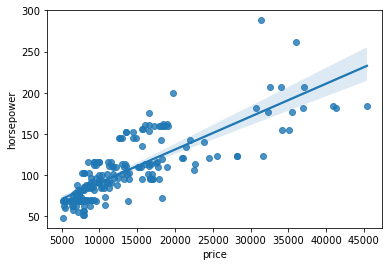

In [42]:
sns.regplot(y=df_dummie['horsepower'], x=df_dummie['price'])

### Модель с множественными нп. Два варианта:  
1 - все предикторы,  
2 - все (predict), кроме бренда/company (predict_wo_company) 

Попробуем выбрать из этих моделей самую удачную

In [43]:
predict = df_dummie.drop(['price'], axis=1) # 1
predict_wo_company = df_dummie.drop(['price', 'company_audi', 'company_bmw', # 2
       'company_buick', 'company_chevrolet', 'company_dodge', 'company_honda',
       'company_isuzu', 'company_jaguar', 'company_mazda', 'company_mercury',
       'company_mitsubishi', 'company_nissan', 'company_peugeot',
       'company_plymouth', 'company_porsche', 'company_renault',
       'company_saab', 'company_subaru', 'company_toyota',
       'company_volkswagen', 'company_volvo'], axis=1)

In [44]:
# 1
X = sm.add_constant(predict)  # добавить константу, чтобы был свободный член
model = sm.OLS(df_dummie.price, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           4.86e-89
Time:                        15:47:55   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.472e+

In [45]:
# 2
X = sm.add_constant(predict_wo_company)  # добавить константу, чтобы был свободный член
model = sm.OLS(df_dummie.price, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           9.86e-81
Time:                        15:47:56   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+

Хотя марки машин и объясняют какую-то часть общей дисперсии в данных, эта часть не самая большая - около 4%. На фоне того, как эта переменная усложняет модель дополнительными статнезначимыми коэффициентами, мы можем принять решение выкинуть её из модели либо дополнительно переделать. Однозначно правильного решения тут нет.

<b>Но допустим, что мы действительно решили избавиться от этого предиктора марка авто (company) и взять вторую модель с предыдущего шага, тогда:  
- Выбранная модель объясняет примерно 90% дисперсии (окр. до целого).  
- Среди предикторов 10 из 27 оказались не значимыми (p > 0.05).
- Пример интерпретации: при единичном изменении показателя horsepower, цена возрастает на 86.8164 еденицы</b>